# Decision Trees:

# A. Training and Visualizing a Decision Tree:

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

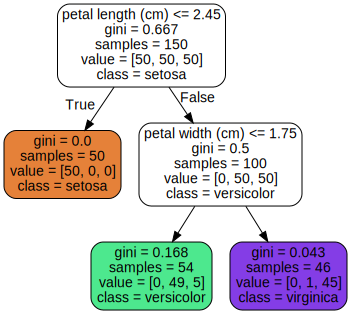

In [3]:
from graphviz import Source

Source.from_file("iris_tree.dot")

# B. Making Predictions :

* Decision Trees require very little data preparation. They don't require feature scaling or centering.

* Root Node 
    * Top node
    * Depth 0
* Leaf Node
    * Child node that does not have any child nodes.

* Split Node
    * Child node w/ 2 or more child nodes.

* Node's `sample` attribute counts how many training instances it applies to.
* Node's `value` attribute tells you how many training instances of each class this node applies to.
* Node's `gini` attribute measures Gini impurity:
    * A node is **pure** (`gini`=0) if all training instances applies to belong to the same class.
    * Gini Impurity:
        * $G_i\ =\ 1\ -\ \sum_{k=1}^{n}p_{i,k}^2$ ,where
            * $G_i$ is the gini impurity of the $i^{th}$ node.
            * $p_{i,k}$ is the ratio of the class $k$ instance among the training instances in the $i^{th}$  node.

* The tree structure is available via the classifier's `tree_` attribute.

* sklearn uses the CART algorithm, w/c produces only binary trees (split nodes always have exactly 2 children).
    * Other algorithms, such as ID3, can produce decision trees w/ nodes that have more than 2 children.

In [4]:
help(tree_clf.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")


tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
;

# C. Estimating Class Probabilities :

* A decision tree can also estimate the probability that an instance belongs to a particular class $k$.
    * It traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node.


In [5]:
tree_clf.predict_proba([[5, 1.5]]).round(2)

array([[0.  , 0.91, 0.09]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

# D. The CART Training Algorithm:

* Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train decision trees (also called “growing” trees).
    * The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g., 'petal length ≤ 2.45 cm').
    * To choose feature $k$ and threshold $t_k$, it searches for the pair $(k,t_k)$ that produces the purest subsets, weighted by their size. <br><br>
        * **CART Cost function for classification** : <br>
        $J(k, t_k)\ =\ \frac{m_{left}}{m}{G_{left}}\ +\ \frac{m_{right}}{m}{G_{right}}$ where<br> 
        &emsp; $G_{left/right}$ measures the impurity of the left/right subset <br>
        &emsp; $m_{left/right}$ is the number of instances in the left/right subset. <br><br>
    * Once the CART algorithm has successfully split the training set in 2, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively.
    * It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity.
        * Other hyperparameters also control addional stopping conditions: 
            * `min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes`

* The CART algorithm is a greedy algorithm: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. (A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.)
    * Unfortunately, finding the optimal tree is known to be an NP complete problem. It requires $O(exp(m))$ time, making the problem intractable even for small training sets. This is why we must settle for a "reasonably good" solution when training decision trees.

# E. Computational Complexity:

* Making predictions requires traversing the decision tree from the root to a leaf.
* Predictions are very fast, even when dealing with large training sets.
    * Decision trees generally are approximately balanced, so traversing the decision tree requires going through roughly $O(log_2(m))$ nodes, where $log_2(m)$ is the binary logarithm of $m$ equal to $\frac{log(m)}{log(2)}$.
    * Since each node only requires checking the value of one feature, the overall prediction complexity is $O(log_2(m))$, independent of the number of features.
* The training algorithm compares all features (or less if `max_features` is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n × m log_2(m))$.

# F. Gini Impurity vs. Entropy : 

* By default, the DecisionTreeClassifier class uses the Gini impurity measure, but you can select the entropy impurity measure instead by setting the `criterion` hyperparameter to `"entropy"`.

* In ML, entropy is frequently used as an impurity measure: a set's entropy is zero when it contains instances of only one class.
    * Entropy : <br>
    $H_i\ =\ -\sum_{k=1, p_i,k \neq 0}^{n}\ p_iklog_2(p_i, k)$

* Most of the Gini impurity and entropy lead to similar trees.
    * Gini impurity is slightly faster to compute.
    * However, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.